# Read from File and Convert to Dataframe

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml import Pipeline
import re
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

spark = SparkSession \
    .builder \
    .appName("dataframe-spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

def readandConverttoDF(path):
    fields = StructType([
                StructField("label", IntegerType(), True), 
                StructField("title", StringType(), True),
                StructField("text", StringType(), True),
            ])
    df = spark.read.csv(path, schema = fields, sep = ",").select("title", "text", "label")
    return df

train_data = readandConverttoDF("./data/train.csv")
test_data = readandConverttoDF("./data/test.csv")

# Beware, these prints take approximately 10 minutes in total. You can stop the execution here if you want to examine other cells
train_data.show()
print("Total train data:", train_data.count())
print("Total train data with positive class:", train_data.filter(col('label') == 2).count())
print("Total train data with negative class:", train_data.filter(col('label') == 1).count())
test_data.show()
print("Total test data:", test_data.count())
print("Total test data with positive class:", test_data.filter(col('label') == 2).count())
print("Total test data with negative class:", test_data.filter(col('label') == 1).count())

+--------------------+--------------------+-----+
|               title|                text|label|
+--------------------+--------------------+-----+
|Stuning even for ...|This sound track ...|    2|
|The best soundtra...|I'm reading a lot...|    2|
|            Amazing!|"This soundtrack ...|    2|
|Excellent Soundtrack|I truly like this...|    2|
|Remember, Pull Yo...|If you've played ...|    2|
|an absolute maste...|I am quite sure a...|    2|
|        Buyer beware|"This is a self-p...|    1|
|      Glorious story|I loved Whisper o...|    2|
|    A FIVE STAR BOOK|I just finished r...|    2|
|Whispers of the W...|This was a easy t...|    2|
|          The Worst!|A complete waste ...|    1|
|          Great book|This was a great ...|    2|
|          Great Read|I thought this bo...|    2|
|           Oh please|I guess you have ...|    1|
|Awful beyond belief!|"I feel I have to...|    1|
|Don't try to fool...|It's glaringly ob...|    1|
|A romantic zen ba...|"When you hear fo...|    2|


KeyboardInterrupt: 

# Exploratory Data Analysis

## 1. Checking Null Values

In [12]:
# Beware, these checks take approximately 15 minutes in total.
train_data.where(col("text").isNull()).show()
train_data.where(col("title").isNull()).show()
train_data.where(col("label").isNull()).show()

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+-----+
|title                                                                                                                                                                                                                                                                                                                                                                                         

In [2]:
test_data.where(col("text").isNull()).show()
test_data.where(col("title").isNull()).show()
test_data.where(col("label").isNull()).show()

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+-----+
|title                                                                                                                                                                                                                                                                                                                                                                                                      

## 2. Word Count and Length Text

In [6]:
data_train = train_data.withColumn('wordCount', size(split(col('text'), ' '))).withColumn('textLength', length(col('text')))
data_test = test_data.withColumn('wordCount', size(split(col('text'), ' '))).withColumn('textLength', length(col('text')))
data_train.show()
data_test.show()

+--------------------+--------------------+-----+---------+----------+
|               title|                text|label|wordCount|textLength|
+--------------------+--------------------+-----+---------+----------+
|Stuning even for ...|This sound track ...|    2|       75|       394|
|The best soundtra...|I'm reading a lot...|    2|       91|       470|
|            Amazing!|"This soundtrack ...|    2|       63|       370|
|Excellent Soundtrack|I truly like this...|    2|      116|       721|
|Remember, Pull Yo...|If you've played ...|    2|       77|       425|
|an absolute maste...|I am quite sure a...|    2|      139|       800|
|        Buyer beware|"This is a self-p...|    1|      116|       631|
|      Glorious story|I loved Whisper o...|    2|      103|       506|
|    A FIVE STAR BOOK|I just finished r...|    2|       99|       506|
|Whispers of the W...|This was a easy t...|    2|       58|       270|
|          The Worst!|A complete waste ...|    1|       33|       204|
|     

KeyboardInterrupt: 

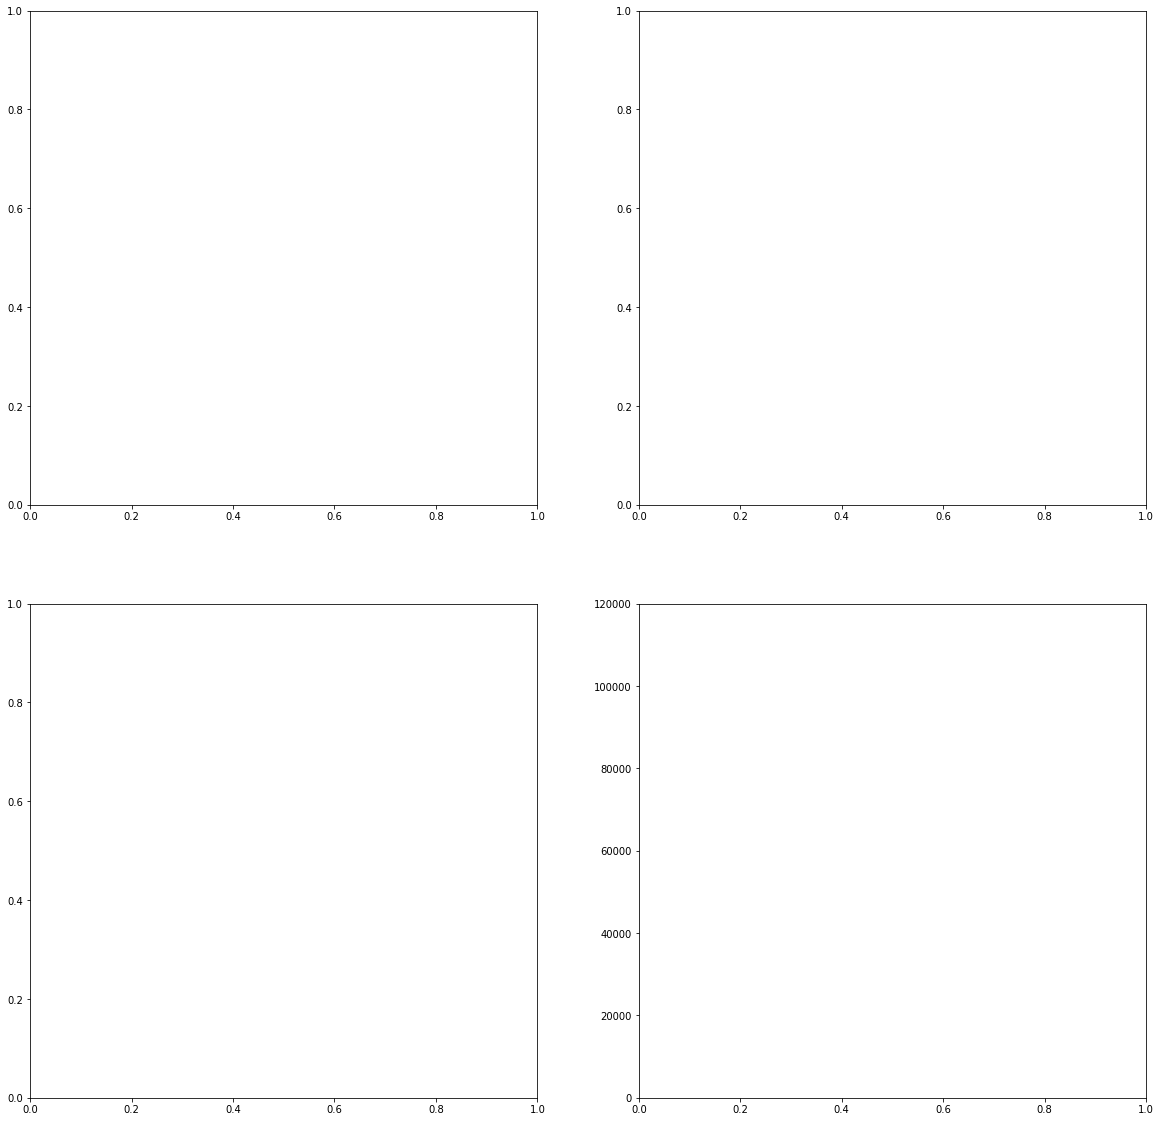

In [7]:
data = data_train.union(data_test)

def plot_to_hist(data):
    data_positive = data.filter(col('label') == 2)
    data_negative = data.filter(col('label') == 1)
    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(20, 20)

    # Beware, these histograms take approximately 15 minutes in total
    hist(ax[0,0], data_negative.select("wordCount").alias("wordCountNegativeClass"), bins = 50)
    ax[0,0].set_title('wordCountNegativeClass')
    hist(ax[0,1], data_positive.select("wordCount").alias("wordCountPositiveClass"), bins = 50)
    ax[0,1].set_title('wordCountPositiveClass')
    hist(ax[1,0], data_negative.select("textLength").alias("textLengthNegativeClass"), bins = 50)
    ax[1,0].set_title('textLengthNegativeClass')
    hist(ax[1,1], data_positive.select("textLength").alias("textLengthPositiveClass"), bins = 50)
    ax[1,1].set_title('textLengthNegativeClass')

plot_to_hist(data_train)

# Data Preprocessing

## 1. Removing Null Reviews

In [18]:
train_data = train_data.filter(train_data.text.isNotNull())
print("Total train data after removing null reviews:", train_data.count())
test_data = test_data.filter(test_data.text.isNotNull())
print("Total test data after removing null reviews:", test_data.count())

Total train data after removing null reviews: 3599987
Total test data after removing null reviews: 400000


## 2. Noise Removal

In [19]:
train_data = train_data.select(regexp_replace(col("text"),"[^a-zA-Z\s]", "").alias("noiseRemoval"), "label")
train_data.show(truncate=False)
test_data = test_data.select(regexp_replace(col("text"),"[^a-zA-Z\s]", "").alias("noiseRemoval"), "label")
test_data.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|noiseRemoval                                                                                                                                                                                                                     

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|noiseRemoval                                                                                                                                               

## 3. Tokenization

In [20]:
tokenizer = Tokenizer(inputCol="noiseRemoval", outputCol="tokens")

## 4. Stopwords Removal

In [21]:
remover = StopWordsRemover(inputCol="tokens", outputCol="tokensWithoutStopwords")

# Feature Extraction

In [23]:
count_vectorizer = CountVectorizer(inputCol="tokensWithoutStopwords", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
label_to_index = StringIndexer(inputCol = "label", outputCol = "target")

pipeline = Pipeline(stages=[tokenizer, remover, count_vectorizer, idf, label_to_index])

fitting = pipeline.fit(train_data)
train_data = fitting.transform(train_data)
test_data = fitting.transform(test_data)
train_data.show()
test_data.show()

+--------------------+-----+--------------------+----------------------+--------------------+--------------------+------+
|        noiseRemoval|label|              tokens|tokensWithoutStopwords|         rawFeatures|            features|target|
+--------------------+-----+--------------------+----------------------+--------------------+--------------------+------+
|This sound track ...|    2|[this, sound, tra...|  [sound, track, be...|(262144,[13,14,31...|(262144,[13,14,31...|   0.0|
|Im reading a lot ...|    2|[im, reading, a, ...|  [im, reading, lot...|(262144,[2,15,20,...|(262144,[2,15,20,...|   0.0|
|This soundtrack i...|    2|[this, soundtrack...|  [soundtrack, favo...|(262144,[0,3,8,42...|(262144,[0,3,8,42...|   0.0|
|I truly like this...|    2|[i, truly, like, ...|  [truly, like, sou...|(262144,[0,2,3,8,...|(262144,[0,2,3,8,...|   0.0|
|If youve played t...|    2|[if, youve, playe...|  [youve, played, g...|(262144,[4,30,31,...|(262144,[4,30,31,...|   0.0|
|I am quite sure a...|  